<a href="https://colab.research.google.com/github/vin136/Machine-Learning-Interview-Questions/blob/main/Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dtreeviz feature_engine pybaobabdt xgbfir shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 2.5 MB/s eta 0:00:00


In [4]:
#Imports
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib.request
import zipfile



In [6]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

def extract_zip(src,dst,member_name):
  url = src
  fname = dst
  fin = urllib.request.urlopen(url)
  data = fin.read()
  with open(dst,mode='wb') as fout:
    fout.write(data)
  with zipfile.ZipFile(dst) as z:
    kag = pd.read_csv(z.open(member_name))
    kag_questions = kag.iloc[0]
    raw = kag.iloc[1:]
    return raw

raw = extract_zip(url,fname,member_name)

<ipython-input-6-4b46b7ad170c>:13: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))


In [84]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)


def tweak_kag(df_):
  return (df_.
          assign(
              age = df_.Q2.str.slice(0,2).astype(int),
              education=df_.Q4.replace({'Master’s degree': 18,
                         'Bachelor’s degree': 16,
                         'Doctoral degree': 20,
                         'Some college/university study without earning a bachelor’s degree': 13,
                         'Professional degree': 19,
                         'I prefer not to answer': None,
                         'No formal education past high school': 12}),
                 major = (df_.Q5
                              .pipe(topn, n=3)
                              .replace({
                        'Computer science (software engineering, etc.)': 'cs',
                        'Engineering (non-computer focused)': 'eng',
                        'Mathematics or statistics': 'stat'})),
                 years_exp = (df_.Q8.str.replace('+','', regex=False).str.split('-', expand=True).iloc[:,0].astype(float)),
                 compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
                           .str.replace('I do not wish to disclose my approximate yearly compensation', '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)
                                    ),
                 python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                       r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                       sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
                 

          )
          .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,education,major,years_exp,compensation,python,r,sql'.split(',')]   
          
          )



In [56]:
# kag = tweak_kag(raw)
# kag_X = kag.drop(columns='title')
# kag_y = (kag.title == 'Data Scientist')
# kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
#     kag_X, kag_y, stratify=kag_y, random_state=42)

In [85]:
class TweakKagTransformer(base.BaseEstimator,
                          base.TransformerMixin):
  def __init__(self,ycol=None):
    self.ycol = ycol

  def transform(self,X):
    return tweak_kag(X)

  def fit(self,X,y=None):
    return self



def get_rawX_y(df,y_col):
  raw = (df.query('Q3.isin(["United States of America","India","China"])and Q6.isin(["Data Scientist","Software Engineer"])'))
  return raw.drop(columns=[y_col]),raw[y_col]

In [86]:
kag_pl = pipeline.Pipeline(
    [('tweak',TweakKagTransformer()),
     ('cat',encoding.OneHotEncoder(
        top_categories=5,drop_last=True,
        variables = ['Q1','Q3','major']
     )),
     ('num_impute',imputation.MeanMedianImputer(imputation_method='median',
                                                variables=['education','years_exp']))]
                           
                           

)

kag_X,kag_Y = get_rawX_y(raw,'Q6')

In [80]:
len(kag_Y),len(kag_X)

(3015, 3015)

In [60]:
kag_X.isna().sum()

Time from Start to Finish (seconds)       0
Q1                                        0
Q1_OTHER_TEXT                             0
Q2                                        0
Q3                                        0
                                       ... 
Q50_Part_5                             2511
Q50_Part_6                             2884
Q50_Part_7                             2656
Q50_Part_8                             2934
Q50_OTHER_TEXT                            0
Length: 394, dtype: int64

In [87]:
kag_X_train,kag_X_test,kag_y_train,kag_y_test = model_selection.train_test_split(
    kag_X,kag_Y,test_size = 0.3,random_state=42,stratify=kag_Y
)

In [82]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

In [88]:
X_train = kag_pl.fit_transform(kag_X_train,kag_y_train)
X_test = kag_pl.transform(kag_X_test)


In [91]:
#exploration
(X_train
 .assign(data_scientist= kag_y_train == 'Data Scientist')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu',vmax=1,vmin=-1)
 .set_sticky(axis='index'))


,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
education,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540
Q1_Prefer to self-describe,0.002701,0.016784,0.049881,-0.000553,-0.004454,-0.018499,-0.094664,-0.019201,-0.004473,1.000000,0.043458,-0.036505,-0.013390,-0.017500,0.053790,-0.022049,-0.015796,0.017819


<Axes: xlabel='r'>

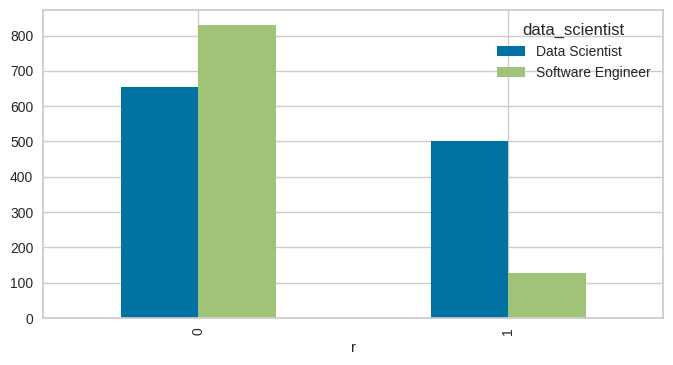

In [98]:
# r is highly correlated,let's check it's plot

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,4))
(X_train
 .assign(data_scientist= kag_y_train)
 .groupby('r')
 .data_scientist
 .value_counts()
 .unstack()
 .plot.bar(ax=ax)


 )

In [ ]:
_